# Sentiment classification

## Model: Logistic regression

In [1]:
import tensorflow as tf
# load dataset from module keras.datasets.imdb
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.imdb.load_data()


(25000,)

In [2]:
INDEX_FROM = 3  
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {k:(v+INDEX_FROM) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i , word) for (word, i) in word_index.items()
)

### Data cleaning

In [3]:
import numpy as np
import pandas as pd
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x.resize(x.shape[0],1)
y.resize(y.shape[0],1)

data = np.concatenate((x,y), axis=1)
df = pd.DataFrame(data=data,
                  index = [i for i in range(data.shape[0])],
                  columns=['review', 'sentiment'])



In [4]:
# check if exist null review
df['review'].isnull().values.any()

False

In [5]:
# remove newline(br) in each review
def remove_new_line_in_review(review):
    new_list = [x for x in review if x!=7 ]
    return new_list

df['review'] = df['review'].apply(lambda review: remove_new_line_in_review(review))

# convert list of word index to text
def word_index_to_text(review):
    text = " ".join(inverted_word_index[i] for i in review)
    return text
df['review'] = [word_index_to_text(review) for review in df['review']]


In [6]:
import re
# import nltk
# nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_html_tag(text):
    return re.sub(r'<[^<]+>','',text)

def data_processing(text):
    text= text.lower()

    # remove html tags
    text = remove_html_tag(text)

    # remove single chars
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    # filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(text_tokens)
    # return text

In [7]:
df.review = df['review'].apply(lambda x: data_processing(x))
# import nltk
# nltk.download('punkt')

In [8]:
df.head()

,review,sentiment
0,this film was just brilliant casting location ...,1
1,big hair big boobs bad music and giant safety ...,0
2,this has to be one the worst films the 1990s w...,0
3,the scots excel at storytelling the traditiona...,1
4,worst mistake my life br br picked this movie ...,0


### review distribution

In [9]:
df['no. words'] = df['review'].str.len()



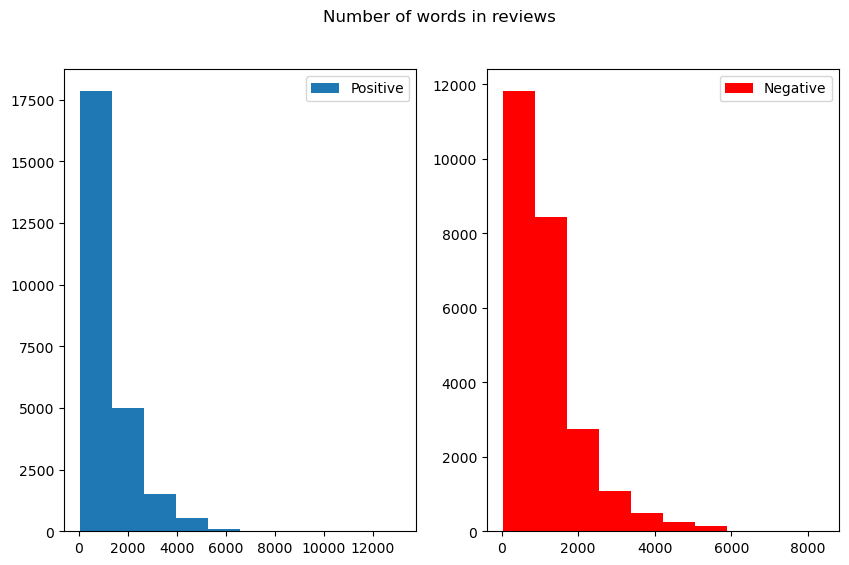

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].hist(df[df['sentiment']==1]['no. words'], label='Positive')
ax[0].legend(loc='upper right')
ax[1].hist(df[df['sentiment']==0]['no. words'], label='Negative', color='red')
ax[1].legend(loc='upper right')
fig.suptitle("Number of words in reviews")
plt.show()

In [11]:
pos_reviews = df[df['sentiment']==1]['review']
neg_reviews = df[df['sentiment']==1]['review']

In [12]:
from collections import Counter
count = Counter()
for text in pos_reviews.values:
    for word in text.split():
        count[word] +=1
count.most_common(15)


[('the', 341264),
 ('and', 176596),
 ('to', 131307),
 ('is', 111826),
 ('in', 99229),
 ('br', 97954),
 ('it', 78177),
 ('this', 69637),
 ('that', 66838),
 ('as', 51098),
 ('with', 45712),
 ('for', 44235),
 ('was', 43332),
 ('film', 41020),
 ('but', 40711)]

In [13]:
pos_words = pd.DataFrame(data= count.most_common(15), columns=['word', 'count'])
pos_words.head()

,word,count
0,the,341264
1,and,176596
2,to,131307
3,is,111826
4,in,99229


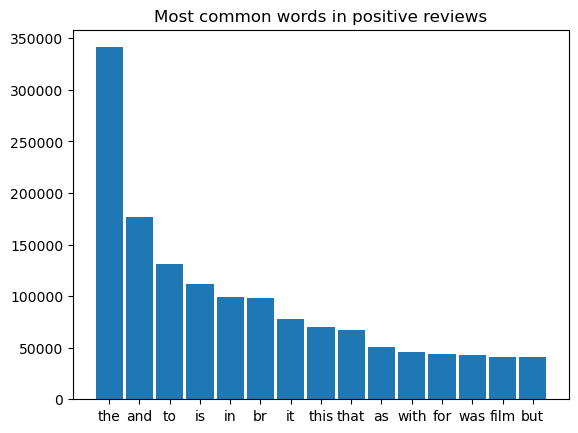

In [14]:
fig, ax = plt.subplots()
ax.bar(pos_words['word'],pos_words['count'], align='center', width=0.9, linewidth=1)
ax.set_title('Most common words in positive reviews')
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = df['review']
Y = df['sentiment']
vect = TfidfVectorizer()
X = vect.fit_transform(df['review'])
lab = preprocessing.LabelEncoder()
Y = lab.fit_transform(Y) # just to convert type(Y) from int to uint32
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [16]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

type(Y[0])

Size of x_train:  (35000, 79319)
Size of y_train:  (35000,)
Size of x_test:  (15000, 79319)
Size of y_test:  (15000,)


numpy.int32

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(x_train, y_train)
model_pred = model.predict(x_test)
model_acc = accuracy_score(model_pred, y_test)
print("Test accuracy: {:.2f}%".format(model_acc*100))


Test accuracy: 89.71%


Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb_pred = nb.predict(x_test)
nb_acc = accuracy_score(nb_pred, y_test)
print("Test accuracy: {:.2f}%".format(nb_acc*100))

Test accuracy: 86.27%


Support vector machine

In [19]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

Test accuracy: 89.83%


neuron network

In [26]:
x_train[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 206 stored elements and shape (1, 79319)>

In [25]:
def padding(sequences , dim = 10000):
    results = np.zeros((len(sequences), dim))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = padding(x_train)
x_test = padding(x_test)

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [21]:
model = tf.keras.models.Sequential()
# Input - Layer
model.add(tf.keras.layers.Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - tf.keras.Layers
model.add(tf.keras.layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(50, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))


c:\Users\legolas\anaconda3\envs\tf_cpu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [24]:
results = model.fit(
 x_train, y_train,
 epochs= 2,
 batch_size = 500,
 validation_data = (x_test, y_test)
)

Epoch 1/2


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 10000, but received input with shape (500, 79319)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(500, 79319), dtype=float32)
  • training=True
  • mask=None

In [ ]:

from keras_preprocessing.sequence import pad_sequences
# Padding all reviews to fixed length 100

maxlen = 100



TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [ ]:
snn_model = tf.keras.models.Sequential()
embedding_layer = tf.keras.layers.Embedding(
    input_dim = x_train.shape[1],
    output_dim = 100,
    input_length = 100, 
    trainable = False,
    weights = [x_train]
)
snn_model.add(embedding_layer)
snn_model.add(tf.keras.layers.Flatten())
snn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#model compiling
snn_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])
snn_model.summary()

c:\Users\legolas\anaconda3\envs\tf_cpu\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


ValueError: Layer embedding weight shape (79319, 100) is not compatible with provided weight shape (35000, 79319).